In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# from keras.layers import Input
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras import layers
# from tensorflow.keras.models import Sequential

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import layers

In [76]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [155]:
import pathlib
# Extract data from the keras_png_slices_data
PATH = 'AKOA_Analysis'

data_dir = pathlib.Path(PATH)

In [156]:
image_count = len(list(data_dir.glob('right_knee/*.png')))
print(image_count)
image_count = len(list(data_dir.glob('left_knee/*.png')))
print(image_count)

10560
7640


10560


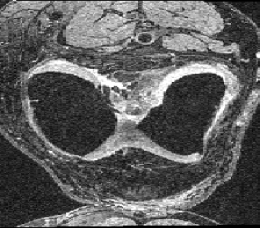

In [157]:
right_knee = list(data_dir.glob('right_knee/*RIGHT*')) + list(data_dir.glob('right_knee/*R_I_G_H_T*'))
print(len(right_knee))
PIL.Image.open(str(right_knee[0]))

7640


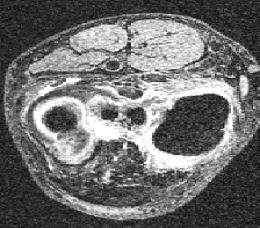

In [158]:
left_knee = list(data_dir.glob('left_knee/*LEFT*')) + list(data_dir.glob('left_knee/*L_E_F_T*'))
print(len(left_knee))
PIL.Image.open(str(left_knee[0]))

In [159]:
batch_size = 32
img_height = 256
img_width = 256

In [175]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode="grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18200 files belonging to 2 classes.
Using 14560 files for training.


In [176]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode="grayscale",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18200 files belonging to 2 classes.
Using 3640 files for validation.


In [162]:
class_names = train_ds.class_names
print(class_names)

['left_knee', 'right_knee']


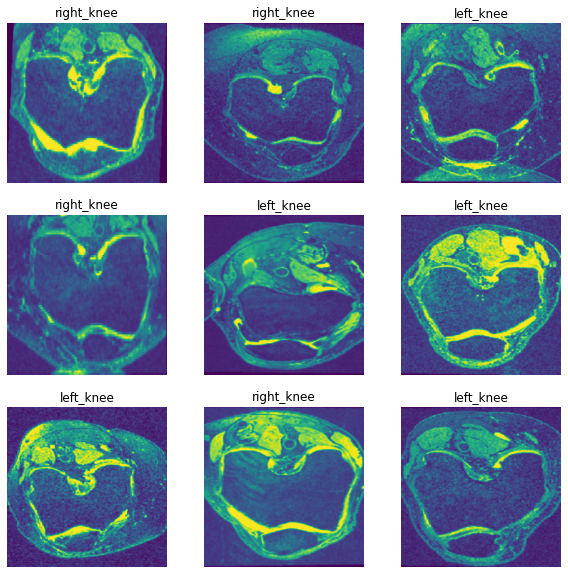

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [164]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32,)


In [165]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32,)


In [166]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [89]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.08765319 1.0


In [187]:
# Build U-Net model
inputs = Input((img_height, img_width, 1))

n1 = experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (n1)
# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((3, 3)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((3, 3)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((3, 3)) (c3)

# c4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# # c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# p4 = MaxPooling2D(pool_size=(3, 3)) (c4)

# c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# # c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
# p5 = MaxPooling2D(pool_size=(3, 3)) (c5)

# c6 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
# # c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
# p6 = MaxPooling2D(pool_size=(3, 3)) (c6)

f1 = Flatten() (p3)
d1 = Dense(512, activation='elu') (f1)
d2 = Dropout(0.2) (d1)
outputs = Dense(1, activation='sigmoid') (d2)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
rescaling_37 (Rescaling)     (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_454 (Conv2D)          (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_455 (Conv2D)          (None, 85, 85, 32)        4640      
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_456 (Conv2D)          (None, 28, 28, 64)      

In [177]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1)
]

In [188]:
epochs=4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=callbacks,
  epochs=epochs
)

Epoch 1/4
455/455 [==============================] - 66s 144ms/step - loss: 0.2342 - accuracy: 0.9346 - val_loss: 4.7178e-04 - val_accuracy: 1.0000
Epoch 2/4
455/455 [==============================] - 66s 144ms/step - loss: 5.3951e-04 - accuracy: 1.0000 - val_loss: 1.3249e-04 - val_accuracy: 1.0000
Epoch 3/4
455/455 [==============================] - 65s 143ms/step - loss: 9.4973e-05 - accuracy: 1.0000 - val_loss: 7.3071e-05 - val_accuracy: 1.0000
Epoch 4/4
455/455 [==============================] - 67s 148ms/step - loss: 5.5817e-05 - accuracy: 1.0000 - val_loss: 4.6800e-05 - val_accuracy: 1.0000


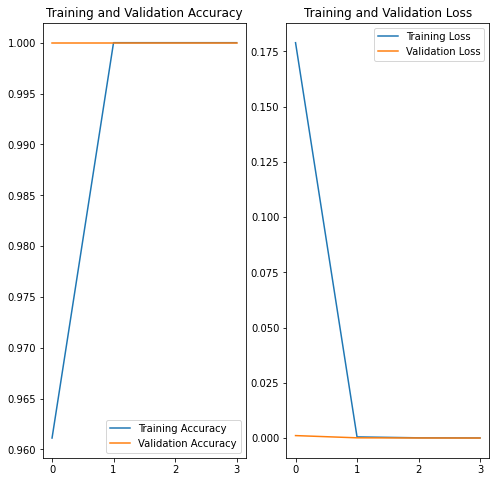

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)